This python code is used to analysis land coupling regime

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
import shutil
from scipy.spatial import distance
import metpy

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import sys, os, time, warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')

In [2]:
import xesmf as xe
var_name = 't2max'

vfile = sorted(glob.glob('/land1/GloSea/G6_HCST/'+var_name+'/*.nc'))
data = xr.open_dataset(vfile[0])
data.coords['longitude'] = (data.coords['longitude'] + 180) % 360 - 180
data = data.sortby(data.longitude)

ds_out = xr.Dataset({"lat": (["lat"], data.latitude.values), "lon": (["lon"], data.longitude.values), })

In [3]:
vfile = sorted(glob.glob('/land1/GLEAM/v3.5a/daily/*/SH_*_GLEAM_v3.5a.nc'))
# print(vfile[11:37])
# sys.exit()

data = xr.open_mfdataset(vfile[11:37],concat_dim='time',combine='nested')['SH']
# sys.exit()

# data = data.rename({'longitude': 'lon', 'latitude': 'lat'})
# data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
# data = data.sortby(data.lon)
data = data.reindex(lat=data.lat[::-1])

regridder = xe.Regridder(data, ds_out, "bilinear")
sh_rgd = regridder(data)
del data

In [4]:
vfile = sorted(glob.glob('/land1/GLEAM/v3.5a/daily/*/Et_*_GLEAM_v3.5a.nc'))
# print(vfile[11:37])
# sys.exit()

data = xr.open_mfdataset(vfile[11:37],concat_dim='time',combine='nested')['Et']
# sys.exit()

# data = data.rename({'longitude': 'lon', 'latitude': 'lat'})
# data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
# data = data.sortby(data.lon)
data = data.reindex(lat=data.lat[::-1])

regridder = xe.Regridder(data, ds_out, "bilinear")
et_rgd = regridder(data)
del data

In [5]:
vfile = sorted(glob.glob('/land1/GLEAM/v3.5a/daily/*/SMsurf_*_GLEAM_v3.5a.nc'))
# print(vfile[11:37])
# sys.exit()

data = xr.open_mfdataset(vfile[11:37],concat_dim='time',combine='nested')['SMsurf']
# sys.exit()

# data = data.rename({'longitude': 'lon', 'latitude': 'lat'})
# data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
# data = data.sortby(data.lon)
data = data.reindex(lat=data.lat[::-1])

regridder = xe.Regridder(data, ds_out, "bilinear")
sm_rgd = regridder(data)
del data

In [6]:
lh_rgd = et_rgd * 28.94
rad_rgd = lh_rgd + sh_rgd
del et_rgd

In [10]:
dir='/land1/GloSea/G5_HCST/'
nlead = 2

ens_g5 = 3
syear_g5 = 1993
eyear_g5 = 2016
season_g5 = "MJJA"

if season_g5 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g5 == "DJF":
    mons = [1,2,12]
elif season_g5 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g5 == "SON":
    mons = [x for x in range(9,12)]
elif season_g5 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g5 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g5,eyear_g5+1)]
days = ['01', '09', '17', '25']
init_dates = [None] * len(mons) * len(days)

cnt = 0
for im in mons:
    for id in days:
        init_dates[cnt] = '{:02d}{}'.format(im,id)
        cnt = cnt + 1
        


g5_sm = xr.DataArray(data = np.empty([len(years),ens_g5,len(init_dates),nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                     dims=["years","ensembles","init_dates","leads","lat","lon"],
                     coords = dict(years=(["years"], years),
                                   ensembles=(["ensembles"], [x for x in range(ens_g5)]),
                                   init_dates=(["init_dates"], init_dates),
                                   leads=(["leads"], [x for x in range(nlead)]),
                                   lat=(["lat"], ds_out.lat.values),
                                   lon=(["lon"], ds_out.lon.values),
                                  )
                    )
g5_lh  = g5_sm.copy(deep=True)
g5_sh  = g5_sm.copy(deep=True)
obs_sm  = xr.DataArray(data = np.empty([len(years),len(init_dates),nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                     dims=["years","init_dates","leads","lat","lon"],
                     coords = dict(years=(["years"], years),
                                   init_dates=(["init_dates"], init_dates),
                                   leads=(["leads"], [x for x in range(nlead)]),
                                   lat=(["lat"], ds_out.lat.values),
                                   lon=(["lon"], ds_out.lon.values),
                                  )
                    )
obs_lh  = obs_sm.copy(deep=True)
obs_sh  = obs_sm.copy(deep=True)

for y,yr in enumerate(years):
    print(yr)
    for i,id in enumerate(init_dates):      
        vfile = sorted(glob.glob(dir+'lh/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['lh'].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'})
        
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data1.time), freq='D')
              
        g5_lh[y,:,i,0,:,:] = data1.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        g5_lh[y,:,i,1,:,:] = data1.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        obs_lh[y,i,0,:,:] = lh_rgd.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        obs_lh[y,i,1,:,:] = lh_rgd.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data1
        del init_date
        del time_day
        
        
        vfile = sorted(glob.glob(dir+'sh/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sh'].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'})
        
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data1.time), freq='D')
              
        g5_sh[y,:,i,0,:,:] = data1.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        g5_sh[y,:,i,1,:,:] = data1.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        obs_sh[y,i,0,:,:] = sh_rgd.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        obs_sh[y,i,1,:,:] = sh_rgd.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data1
        del init_date
        del time_day
        
        vfile = sorted(glob.glob(dir+'sm/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sm'].isel(level6=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'})
        
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data1.time), freq='D')
              
        g5_sm[y,:,i,0,:,:] = data1.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        g5_sm[y,:,i,1,:,:] = data1.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        obs_sm[y,i,0,:,:] = sm_rgd.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        obs_sm[y,i,1,:,:] = sm_rgd.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data1
        del init_date
        del time_day
        
        # sys.exit()
        

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [11]:
def cal_tci_xr(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    TCI : xarray
        calculated TCI
    R : xarray
        calculated R of TCI
    STD : xarray
        calculated STD of TCI
    """
    R = xr.corr(a,b,dim)
    STD = b.std(dim)
    return R*STD, R, STD

def area_avg_weight(a, lon_str, lat_str):
    weights = np.cos(np.deg2rad(a.lat))
    weights.name = "weights"
    a_weighted = a.weighted(weights)
    weighted_mean = a_weighted.mean(("lon", "lat"))
    return weighted_mean.values.item()

country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='50m',
    facecolor='none')

In [14]:
# del sh_rgd, lh_rgd, sm_rgd
g5_rad  = g5_lh + g5_sh
obs_rad = obs_lh + obs_sh

ecorr_g5 = xr.corr(g5_rad, g5_lh, 'years')
lc_sh_g5,r_sm_sh_g5,_ = cal_tci_xr(g5_sm, g5_sh, 'years')
lc_lh_g5,r_sm_lh_g5,_ = cal_tci_xr(g5_sm, g5_lh, 'years')
# del g5_pr, g5_rad, g5_lh, g5_sm, g5_sh

ecorr_obs = xr.corr(obs_rad, obs_lh, 'years')
lc_sh_obs,r_sm_sh_obs,_ = cal_tci_xr(obs_sm, obs_sh, 'years')
lc_lh_obs,r_sm_lh_obs,_ = cal_tci_xr(obs_sm, obs_lh, 'years')
# del obs_pr, obs_rad, obs_lh, obs_sm, obs_sh

In [15]:
dir='/land1/GloSea/G6_HCST/'
nlead = 2

ens_g6 = 7
syear_g6 = 1993
eyear_g6 = 2016
season_g6 = "MJJA"

if season_g6 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g6 == "DJF":
    mons = [1,2,12]
elif season_g6 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g6 == "SON":
    mons = [x for x in range(9,12)]
elif season_g6 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g6 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g6,eyear_g6+1)]
days = ['01', '09', '17', '25']
init_dates = [None] * len(mons) * len(days)

cnt = 0
for im in mons:
    for id in days:
        init_dates[cnt] = '{:02d}{}'.format(im,id)
        cnt = cnt + 1
        


g6_sm = xr.DataArray(data = np.empty([len(years),ens_g6,len(init_dates),nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                     dims=["years","ensembles","init_dates","leads","lat","lon"],
                     coords = dict(years=(["years"], years),
                                   ensembles=(["ensembles"], [x for x in range(ens_g6)]),
                                   init_dates=(["init_dates"], init_dates),
                                   leads=(["leads"], [x for x in range(nlead)]),
                                   lat=(["lat"], ds_out.lat.values),
                                   lon=(["lon"], ds_out.lon.values),
                                  )
                    )
g6_lh  = g6_sm.copy(deep=True)
g6_sh  = g6_sm.copy(deep=True)

for y,yr in enumerate(years):
    print(yr)
    for i,id in enumerate(init_dates):
        vfile = sorted(glob.glob(dir+'lh/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['lh'].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'})
        
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data1.time), freq='D')
              
        g6_lh[y,:,i,0,:,:] = data1.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        g6_lh[y,:,i,1,:,:] = data1.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data1
        del init_date
        del time_day
        
        
        vfile = sorted(glob.glob(dir+'sh/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sh'].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'})
        
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data1.time), freq='D')
              
        g6_sh[y,:,i,0,:,:] = data1.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        g6_sh[y,:,i,1,:,:] = data1.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data1
        del init_date
        del time_day
        
        vfile = sorted(glob.glob(dir+'sm/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')['sm'].isel(level6=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'})
        
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data1.time), freq='D')
              
        g6_sm[y,:,i,0,:,:] = data1.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        g6_sm[y,:,i,1,:,:] = data1.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data1
        del init_date
        del time_day

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [17]:
g6_rad  = g6_lh + g6_sh

ecorr_g6 = xr.corr(g6_rad, g6_lh, 'years')
lc_sh_g6,r_sm_sh_g6,_ = cal_tci_xr(g6_sm, g6_sh, 'years')
lc_lh_g6,r_sm_lh_g6,_ = cal_tci_xr(g6_sm, g6_lh, 'years')
del g6_rad, g6_lh, g6_sm, g6_sh

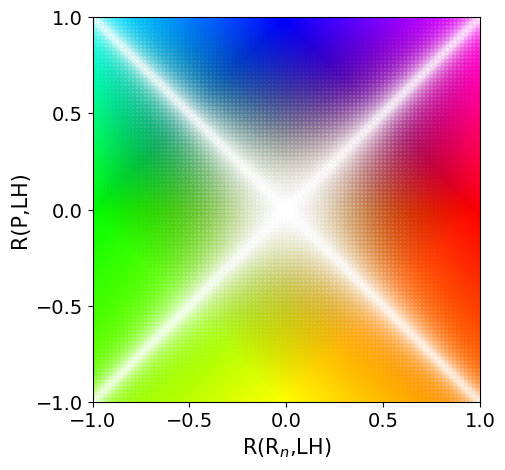

In [18]:
key_xy_points = np.array([ [1,1],[-1,1],[1,-1],[-1,-1],    [0,1],[1,0],[0,-1],[-1,0]],dtype=float)
key_xy_RGBs  = np.empty([key_xy_points.shape[0],3],dtype=float)
mval = 1.
key_xy_RGBs[:] = 1.
key_xy_RGBs[key_xy_points.shape[0]-8,:] = [mval,0,mval]
key_xy_RGBs[key_xy_points.shape[0]-7,:] = [0,mval,mval]
key_xy_RGBs[key_xy_points.shape[0]-6,:] = [mval,mval/2,0]
key_xy_RGBs[key_xy_points.shape[0]-5,:] = [mval/2,mval,0]

key_xy_RGBs[key_xy_points.shape[0]-4,:] = [0,0,mval]
key_xy_RGBs[key_xy_points.shape[0]-3,:] = [mval,0,0]
key_xy_RGBs[key_xy_points.shape[0]-2,:] = [mval,mval,0]
key_xy_RGBs[key_xy_points.shape[0]-1,:] = [0,mval,0]

key_xy_points.shape
key_xy_RGBs.shape

def dis_point_to_line(l1, l2, p1):
    return abs((l2[0]-l1[0])*(l1[1]-p1[1]) - (l1[0]-p1[0])*(l2[1]-l1[1])) / np.sqrt(np.square(l2[0]-l1[0]) + np.square(l2[1]-l1[1]))


from scipy.interpolate import griddata

nrows = 1
ncols = 1
fname='./fig/Coupling_regime_colorbar.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(5,5))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
# axs=axs.flatten()

xydata = np.array([(x,y) for x in np.arange(-1.,1.02,0.02) for y in np.arange(-1.,1.02,0.02)], dtype=float)
# xydata = np.array([(x,y) for x in np.arange(-1.,1.01,0.01) for y in np.arange(-1.,1.01,0.01)], dtype=float)

reds = griddata(key_xy_points, key_xy_RGBs.T[0], xydata)
greens = griddata(key_xy_points, key_xy_RGBs.T[1], xydata)
blues = griddata(key_xy_points, key_xy_RGBs.T[2], xydata)

xy_colors_griddata = np.vstack((reds, greens, blues)).T
xy_colors_griddata2 = np.empty([xy_colors_griddata.shape[0],4],dtype=float)
xy_colors_griddata2[:,:3] = xy_colors_griddata
l1 = [-1, -1]
l2 = [ 1,  1]
o1 = [ 1, -1]
o2 = [-1,  1]
for x in range(xy_colors_griddata2[:,3].shape[0]):
    p1 = [xydata.T[0][x], xydata.T[1][x]]
    xy_colors_griddata2[x,3] = ( dis_point_to_line(o1, o2, p1) * dis_point_to_line(l1, l2, p1) ) / 0.5

xy_colors_griddata2 = np.where(xy_colors_griddata2 > 1., 1., xy_colors_griddata2)
xy_colors_griddata2 = np.where(xy_colors_griddata2 < 0., 0., xy_colors_griddata2)

ax.scatter(xydata.T[0], xydata.T[1], c=xy_colors_griddata2)

ax.set_title('',fontsize=18)
ax.tick_params(labelsize=14)
ax.set_xticks(np.arange(-1, 1.5, 0.5))
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.set_xlabel('R(R$_n$,LH)',fontsize=15)
ax.set_ylabel('R(P,LH)',fontsize=15)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

# plt.suptitle('Climate regime colorbar',fontsize=15)
# plt.savefig(fname, dpi=200, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

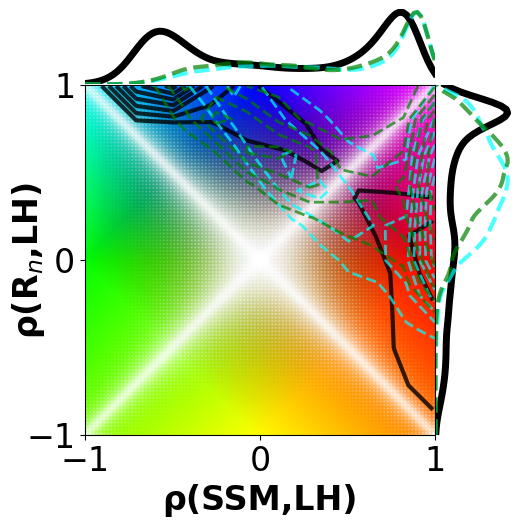

In [19]:
water_var = 'sm'

fname='./fig/Coupling_regime_colorbar_'+water_var+'.png'
fig = plt.figure(figsize=(5,5))

# definitions for the axes
left, width = 0.1, 0.7
bottom, height = 0.1, 0.7
spacing = 0.001

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.15]
rect_histy = [left + width + spacing, bottom, 0.15, height]

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

ax.scatter(xydata.T[0], xydata.T[1], c=xy_colors_griddata2)

if water_var=='pr':
    wname='P'
    xx1 = ecorr_obs.mean(dim=('init_dates','leads')).values.flatten()
    yy1 = wcorr_obs.mean(dim=('init_dates','leads')).values.flatten()
    xx2 = ecorr_g5.mean(dim=('init_dates','leads','ensembles')).values.flatten()
    yy2 = wcorr_g5.mean(dim=('init_dates','leads','ensembles')).values.flatten()
    xx3 = ecorr_g6.mean(dim=('init_dates','leads','ensembles')).values.flatten()
    yy3 = wcorr_g6.mean(dim=('init_dates','leads','ensembles')).values.flatten()
elif water_var=='sm':
    wname='SSM'
    xx1 = ecorr_obs.mean(dim=('init_dates','leads')).values.flatten()
    yy1 = r_sm_lh_obs.mean(dim=('init_dates','leads')).values.flatten()
    xx2 = ecorr_g5.mean(dim=('init_dates','leads','ensembles')).values.flatten()
    yy2 = r_sm_lh_g5.mean(dim=('init_dates','leads','ensembles')).values.flatten()
    xx3 = ecorr_g6.mean(dim=('init_dates','leads','ensembles')).values.flatten()
    yy3 = r_sm_lh_g6.mean(dim=('init_dates','leads','ensembles')).values.flatten()
    
mask = (~np.isnan(xx1)) & (~np.isnan(yy1)) & (~np.isnan(xx2)) & (~np.isnan(yy2)) & (~np.isnan(xx3)) & (~np.isnan(yy3))

H, xedges, yedges = np.histogram2d(xx1[mask], yy1[mask])
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
# ax.contour(np.where(H > 0, H, np.nan), extent=extent, levels = np.arange(15000, 100000, 15000), linestyles='-', linewidths=3, colors='black', alpha=0.8)
ax.contour(np.where(H > 0, H, np.nan), extent=extent, linestyles='-', linewidths=3, colors='black', alpha=0.8)


H, xedges, yedges = np.histogram2d(xx2[mask], yy2[mask])
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
# ax.contour(np.where(H > 0, H, np.nan), extent=extent, levels = np.arange(15000, 100000, 15000), linestyles='--', linewidths=2, colors='darkorange', alpha=0.7)
ax.contour(np.where(H > 0, H, np.nan), extent=extent, linestyles='--', linewidths=2, colors='aqua', alpha=0.7)

H, xedges, yedges = np.histogram2d(xx3[mask], yy3[mask])
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
ax.contour(np.where(H > 0, H, np.nan), extent=extent, levels = np.arange(15000, 100000, 15000), linestyles='--', linewidths=2, colors='green', alpha=0.7)
ax.contour(np.where(H > 0, H, np.nan), extent=extent, linestyles='--', linewidths=2, colors='green', alpha=0.7)


ax.set_title('',fontsize=18)
ax.tick_params(labelsize=24)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_ylabel('\u03C1(R$_n$,LH)',fontsize=24, weight='bold', labelpad=-15)
# ax.set_xlabel('R(PR,LH)',fontsize=20)
ax.set_xlabel('\u03C1({},LH)'.format(wname),fontsize=24, weight='bold')
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])



ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
    
kde = stats.gaussian_kde(yy1[mask]-0.05)
xx = np.linspace(-1,1, 100)
ax_histx.plot(xx, kde(xx)/kde(xx).max(), color='black', linewidth=5)
ax_histx.set_ylim(0,1.04)

kde = stats.gaussian_kde(yy2[mask]-0.05)
xx = np.linspace(-1,1, 100)
ax_histx.plot(xx, kde(xx)/kde(xx).max(), linestyle='--', color='aqua', linewidth=3, alpha=0.7)
ax_histx.set_ylim(0,1.04)

kde = stats.gaussian_kde(yy3[mask]-0.05)
xx = np.linspace(-1,1, 100)
ax_histx.plot(xx, kde(xx)/kde(xx).max(), linestyle='--', color='green', linewidth=3, alpha=0.7)
ax_histx.set_ylim(0,1.04)


kde = stats.gaussian_kde(xx1[mask]-0.05)
yy = np.linspace(-1,1, 100)
ax_histy.plot(kde(yy)/kde(yy).max(), yy, color='black', linewidth=5)
ax_histy.set_xlim(0,1.04)

kde = stats.gaussian_kde(xx2[mask]-0.05)
yy = np.linspace(-1,1, 100)
ax_histy.plot(kde(yy)/kde(yy).max(), yy, linestyle='--', color='aqua', linewidth=3, alpha=0.7)
ax_histy.set_xlim(0,1.04)

kde = stats.gaussian_kde(xx3[mask]-0.05)
yy = np.linspace(-1,1, 100)
ax_histy.plot(kde(yy)/kde(yy).max(), yy, linestyle='--', color='green', linewidth=3, alpha=0.7)
ax_histy.set_xlim(0,1.04)

ax_histx.axis('off')
ax_histy.axis('off')

plt.savefig(fname, dpi=200, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

In [20]:
def rgd_xy(a,b):
    xydata3 = abs( xydata[:,0] - a.values ) * abs( xydata[:,1] - b.values )
    idx = np.argmin(xydata3)
    return xy_colors_griddata2[idx,:]


obs_sm_rgb  = xr.DataArray(data = np.empty([len(ds_out.lat),len(ds_out.lon),4]) * np.nan, 
                    dims=["lat","lon","RGBs"],
                    coords = dict(lat=(["lat"], ds_out.lat.values),
                                  lon=(["lon"], ds_out.lon.values),
                                  RGBs=(["RGBs"], [x for x in range(4)]),
                                 )
                   )

g5_sm_rgb = obs_sm_rgb.copy(deep=True)
g6_sm_rgb = obs_sm_rgb.copy(deep=True)



for x in range(len(ds_out.lon)):
    for y in range(len(ds_out.lat)):
        # if oe[0,y,x] != np.nan and me[0,0,y,x] != np.nan:
        if np.count_nonzero(np.isnan(ecorr_obs[:,:,y,x])) == 0 and np.count_nonzero(np.isnan(ecorr_g6[:,:,:,y,x])) == 0:
            obs_sm_rgb[y,x,:] = rgd_xy(r_sm_lh_obs.mean(dim=('leads','init_dates'))[y,x],ecorr_obs.mean(dim=('leads','init_dates'))[y,x])
            g5_sm_rgb[y,x,:] = rgd_xy(r_sm_lh_g5.mean(dim=('leads','init_dates','ensembles'))[y,x],ecorr_g5.mean(dim=('leads','init_dates','ensembles'))[y,x])
            g6_sm_rgb[y,x,:] = rgd_xy(r_sm_lh_g6.mean(dim=('leads','init_dates','ensembles'))[y,x],ecorr_g6.mean(dim=('leads','init_dates','ensembles'))[y,x])

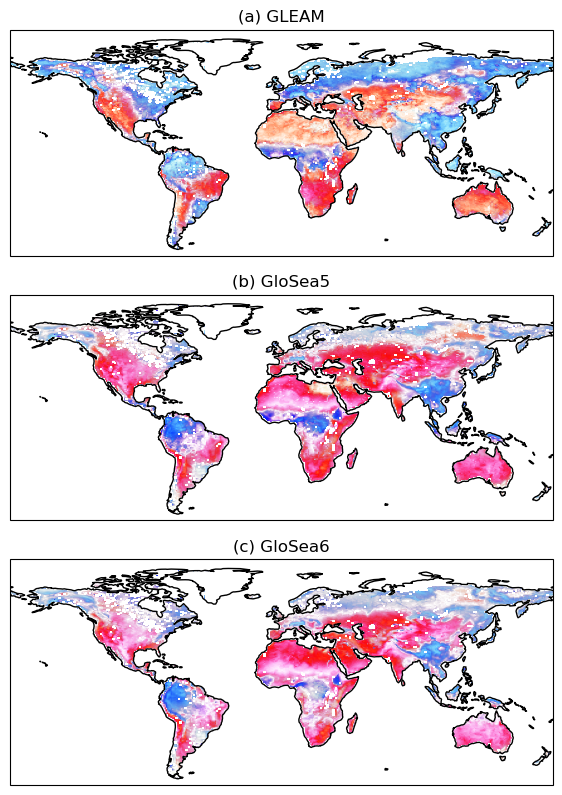

In [21]:
from matplotlib import pyplot
from shapely.geometry.polygon import LinearRing, Polygon

water_var = 'sm'
nrows = 3
ncols = 1

region = 'glb'
if region == 'glb':
    lons = [-180,180]
    lats = [-60,90]
elif region == 'EA':
    lons = [90,150]
    lats = [20,60]
    
fname='./fig/Coupling_regime_'+region+'_'+water_var+'.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(7,10))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    # print(pp)
    if pp==0:
        if water_var=='pr':
            titles = ['(a) MSWEP-GLEAM','(b) GloSea5','(c) GloSea6']
            data = obs_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
        elif water_var=='sm':
            titles = ['(a) GLEAM','(b) GloSea5','(c) GloSea6']
            data = obs_sm_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))            
    elif pp==1:
        if water_var=='pr':
            data = g5_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
        elif water_var=='sm':
            data = g5_sm_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
    elif pp==2:
        if water_var=='pr':
            data = g6_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
        elif water_var=='sm':
            data = g6_sm_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
    
    data_T = data[::-1,:,:]
    cs=axs[pp].imshow(data_T, extent=[data.lon.values.min(), data.lon.values.max(), data.lat.values.min(), data.lat.values.max()])
    
    # Title each subplot with the name of the model
    axs[pp].set_title(titles[pp])

    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='black', linestyle='-', linewidth=1, alpha=0.7)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='black', linestyle='--', linewidth=0.8, alpha=0.5)
    
    
        
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(wspace=0., hspace=0.1)


plt.savefig(fname, dpi=200, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

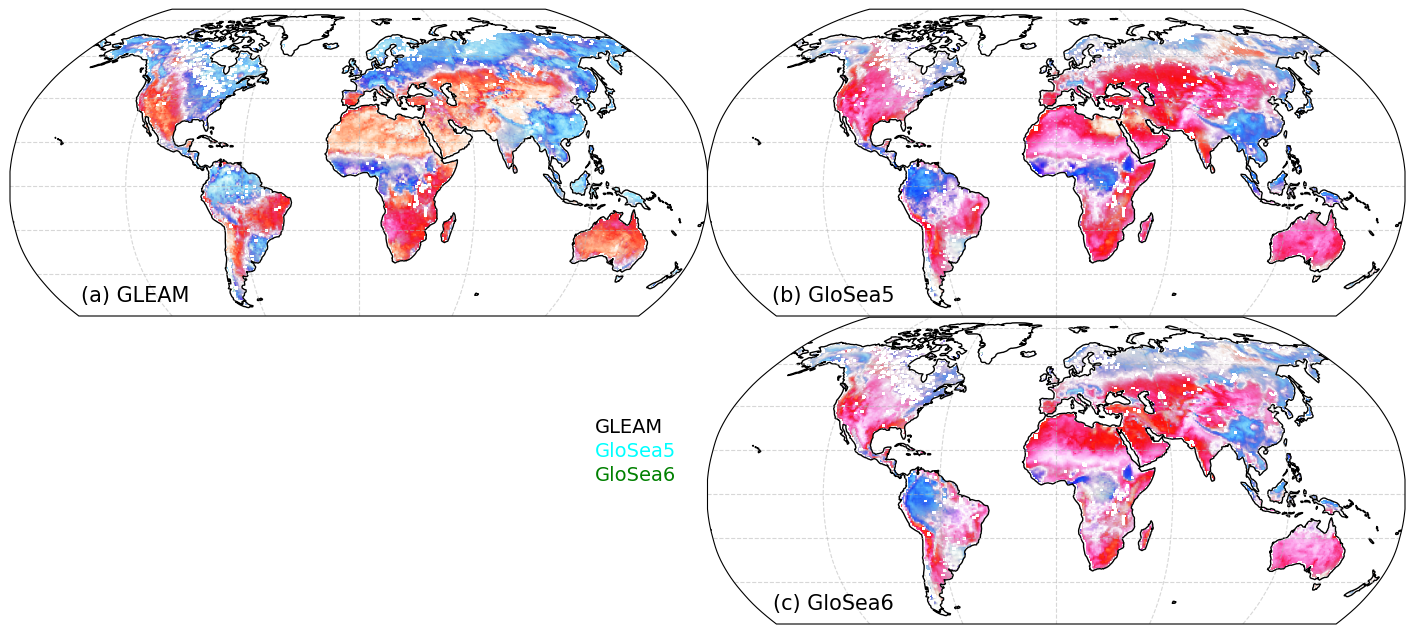

In [75]:
from matplotlib import pyplot

water_var = 'sm'
nrows = 2
ncols = 2

region = 'glb'
if region == 'glb':
    lons = [-180,180]
    lats = [-60,90]

    
titles = ['(a) GLEAM','(b) GloSea5','','(c) GloSea6']
titles1 = ['a','b','','c']
fname='./fig/Coupling_regime_'+region+'_'+water_var+'2.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(18,8))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

for pp in range(nrows*ncols):
    
    if pp==0:
        data = obs_sm_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))            
    elif pp==1:
        data = g5_sm_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
    elif pp==3:
        data = g6_sm_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
        
    axs[pp].set_extent([data.lon.values.min(), data.lon.values.max(), data.lat.values.min(), data.lat.values.max()])
    
    data_T = data[::-1,:,:]
    cs=axs[pp].imshow(data_T, extent=[data.lon.values.min(), data.lon.values.max(), data.lat.values.min(), data.lat.values.max()], transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    # axs[pp].set_title(titles1[pp],y=0.15,x=0.2,fontsize=15)
    axs[pp].set_title(titles[pp],x=0.18,y=0.02,fontsize=15)

    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the grid-lines for each subplot
    # axs[pp].gridlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='black', linestyle='-', linewidth=1, alpha=0.7)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='black', linestyle='--', linewidth=0.8, alpha=0.5)
    
    # Draw gridlines except for xlabels_top and ylabels_left
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    
        
# Delete the unwanted axes
for i in [2]:
    fig.delaxes(axs[i])

fig.text(0.45,0.35, 'GLEAM', color='black', size=14, rotation=0, horizontalalignment="left")
fig.text(0.45,0.32, 'GloSea5', color='aqua', size=14, rotation=0, horizontalalignment="left")
fig.text(0.45,0.29, 'GloSea6', color='green', size=14, rotation=0, horizontalalignment="left")

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(wspace=0., hspace=0.)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

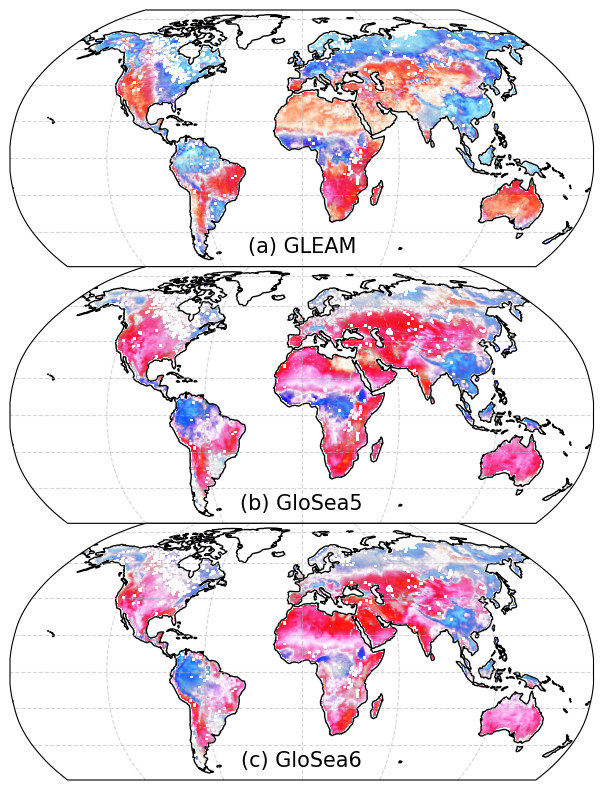

In [66]:
from matplotlib import pyplot
from shapely.geometry.polygon import LinearRing, Polygon

water_var = 'sm'
nrows = 3
ncols = 1

region = 'glb'
if region == 'glb':
    lons = [-180,180]
    lats = [-60,90]
elif region == 'EA':
    lons = [90,150]
    lats = [20,60]
    
fname='./fig/Coupling_regime_'+region+'_'+water_var+'2.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(8,10))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    # print(pp)
    if pp==0:
        if water_var=='pr':
            titles = ['(a) MSWEP-GLEAM','(b) GloSea5','(c) GloSea6']
            data = obs_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
        elif water_var=='sm':
            titles = ['(a) GLEAM','(b) GloSea5','(c) GloSea6']
            data = obs_sm_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))            
    elif pp==1:
        if water_var=='pr':
            data = g5_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
        elif water_var=='sm':
            data = g5_sm_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
    elif pp==2:
        if water_var=='pr':
            data = g6_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
        elif water_var=='sm':
            data = g6_sm_rgb.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
    
    axs[pp].set_extent([data.lon.values.min(), data.lon.values.max(), data.lat.values.min(), data.lat.values.max()])
    
    data_T = data[::-1,:,:]
    cs=axs[pp].imshow(data_T, extent=[data.lon.values.min(), data.lon.values.max(), data.lat.values.min(), data.lat.values.max()], transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    # axs[pp].set_title(titles1[pp],y=0.15,x=0.2,fontsize=15)
    axs[pp].set_title(titles[pp],y=0.02,fontsize=15)

    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the grid-lines for each subplot
    # axs[pp].gridlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='black', linestyle='-', linewidth=1, alpha=0.7)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='black', linestyle='--', linewidth=0.8, alpha=0.5)
    
    # Draw gridlines except for xlabels_top and ylabels_left
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    
        
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(wspace=0., hspace=0.)
plt.savefig(fname, dpi=200, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

In [21]:
w_g5 = np.empty([len(wcorr_g5.ensembles),len(wcorr_g5.init_dates),nlead]) * np.nan
e_g5 = np.empty([len(wcorr_g5.ensembles),len(wcorr_g5.init_dates),nlead]) * np.nan
w_g6 = np.empty([len(wcorr_g6.ensembles),len(wcorr_g6.init_dates),nlead]) * np.nan
e_g6 = np.empty([len(wcorr_g6.ensembles),len(wcorr_g6.init_dates),nlead]) * np.nan

w_sm_g5 = np.empty([len(wcorr_g5.ensembles),len(wcorr_g5.init_dates),nlead]) * np.nan
w_sm_g6 = np.empty([len(wcorr_g6.ensembles),len(wcorr_g6.init_dates),nlead]) * np.nan

for ee in range(len(wcorr_g5.ensembles)):
    w_g5[ee,:,:] = xr.corr( wcorr_obs.stack(point=["lat", "lon"]), wcorr_g5[ee,:,:,:,:].stack(point=["lat", "lon"]), 'point')
    e_g5[ee,:,:] = xr.corr( ecorr_obs.stack(point=["lat", "lon"]), ecorr_g5[ee,:,:,:,:].stack(point=["lat", "lon"]), 'point')
    w_sm_g5[ee,:,:] = xr.corr( r_sm_lh_obs.stack(point=["lat", "lon"]), r_sm_lh_g5[ee,:,:,:,:].stack(point=["lat", "lon"]), 'point')

    
for ee in range(len(wcorr_g6.ensembles)):
    w_g6[ee,:,:] = xr.corr( wcorr_obs.stack(point=["lat", "lon"]), wcorr_g6[ee,:,:,:,:].stack(point=["lat", "lon"]), 'point')
    e_g6[ee,:,:] = xr.corr( ecorr_obs.stack(point=["lat", "lon"]), ecorr_g6[ee,:,:,:,:].stack(point=["lat", "lon"]), 'point')
    w_sm_g6[ee,:,:] = xr.corr( r_sm_lh_obs.stack(point=["lat", "lon"]), r_sm_lh_g6[ee,:,:,:,:].stack(point=["lat", "lon"]), 'point')


In [95]:
nrows = 2
ncols = 3

plot_maps = xr.DataArray(data = np.empty([nrows*ncols,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                    dims=["maps","lat","lon"],
                    coords = dict(maps=(["maps"], [x for x in range(nrows*ncols)]),
                                  lat=(["lat"], ds_out.lat.values),
                                  lon=(["lon"], ds_out.lon.values),
                                 )
                   )
plot_sig = plot_maps.copy(deep=True)
plot_sig2  = plot_maps.copy(deep=True)
plot_maps2 = plot_maps.copy(deep=True)
plot_sig3  = plot_maps.copy(deep=True)
plot_maps3 = plot_maps.copy(deep=True)

plot_maps[0,:,:] = r_sm_lh_obs.mean(dim=('init_dates','leads'))
plot_maps[1,:,:] = r_sm_lh_g5.mean(dim=('init_dates','leads','ensembles'))
plot_maps[2,:,:] = r_sm_lh_g6.mean(dim=('init_dates','leads','ensembles'))
plot_maps[3,:,:] = r_sm_lh_g6.mean(dim=('init_dates','leads','ensembles')) - r_sm_lh_g5.mean(dim=('init_dates','leads','ensembles'))
plot_maps[4,:,:] = r_sm_lh_g5.mean(dim=('init_dates','leads','ensembles')) - r_sm_lh_obs.mean(dim=('init_dates','leads'))
plot_maps[5,:,:] = r_sm_lh_g6.mean(dim=('init_dates','leads','ensembles')) - r_sm_lh_obs.mean(dim=('init_dates','leads'))
plot_sig[3,:,:] = stats.ttest_ind( r_sm_lh_g6.stack(samp=("init_dates", "leads", "ensembles")), r_sm_lh_g5.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig[4,:,:] = stats.ttest_ind( r_sm_lh_obs.stack(samp=("init_dates", "leads")), r_sm_lh_g5.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig[5,:,:] = stats.ttest_ind( r_sm_lh_obs.stack(samp=("init_dates", "leads")), r_sm_lh_g6.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue


plot_maps2[0,:,:] = lc_lh_obs.mean(dim=('init_dates','leads'))
plot_maps2[1,:,:] = lc_lh_g5.mean(dim=('init_dates','leads','ensembles'))
plot_maps2[2,:,:] = lc_lh_g6.mean(dim=('init_dates','leads','ensembles'))
plot_maps2[3,:,:] = lc_lh_g6.mean(dim=('init_dates','leads','ensembles')) - lc_lh_g5.mean(dim=('init_dates','leads','ensembles'))
plot_maps2[4,:,:] = lc_lh_g5.mean(dim=('init_dates','leads','ensembles')) - lc_lh_obs.mean(dim=('init_dates','leads'))
plot_maps2[5,:,:] = lc_lh_g6.mean(dim=('init_dates','leads','ensembles')) - lc_lh_obs.mean(dim=('init_dates','leads'))
plot_sig2[3,:,:] = stats.ttest_ind( lc_lh_g6.stack(samp=("init_dates", "leads", "ensembles")), lc_lh_g5.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig2[4,:,:] = stats.ttest_ind( lc_lh_obs.stack(samp=("init_dates", "leads")), lc_lh_g5.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig2[5,:,:] = stats.ttest_ind( lc_lh_obs.stack(samp=("init_dates", "leads")), lc_lh_g6.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue

sd_lh_obs = lc_lh_obs / r_sm_lh_obs
sd_lh_g5  = lc_lh_g5 / r_sm_lh_g5
sd_lh_g6  = lc_lh_g6 / r_sm_lh_g6
plot_maps3[0,:,:] = sd_lh_obs.mean(dim=('init_dates','leads'))
plot_maps3[1,:,:] = sd_lh_g5.mean(dim=('init_dates','leads','ensembles'))
plot_maps3[2,:,:] = sd_lh_g6.mean(dim=('init_dates','leads','ensembles'))
plot_maps3[3,:,:] = sd_lh_g6.mean(dim=('init_dates','leads','ensembles')) - sd_lh_g5.mean(dim=('init_dates','leads','ensembles'))
plot_maps3[4,:,:] = sd_lh_g5.mean(dim=('init_dates','leads','ensembles')) - sd_lh_obs.mean(dim=('init_dates','leads'))
plot_maps3[5,:,:] = sd_lh_g6.mean(dim=('init_dates','leads','ensembles')) - sd_lh_obs.mean(dim=('init_dates','leads'))
plot_sig3[3,:,:] = stats.ttest_ind( sd_lh_g6.stack(samp=("init_dates", "leads", "ensembles")), sd_lh_g5.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig3[4,:,:] = stats.ttest_ind( sd_lh_obs.stack(samp=("init_dates", "leads")), sd_lh_g5.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig3[5,:,:] = stats.ttest_ind( sd_lh_obs.stack(samp=("init_dates", "leads")), sd_lh_g6.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue

In [116]:
plot_maps4 = xr.DataArray(data = np.empty([nrows*ncols,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                    dims=["maps","lat","lon"],
                    coords = dict(maps=(["maps"], [x for x in range(nrows*ncols)]),
                                  lat=(["lat"], ds_out.lat.values),
                                  lon=(["lon"], ds_out.lon.values),
                                 )
                   )
plot_sig4 = plot_maps4.copy(deep=True)

plot_maps4[0,:,:] = ecorr_obs.mean(dim=('init_dates','leads'))
plot_maps4[1,:,:] = ecorr_g5.mean(dim=('init_dates','leads','ensembles'))
plot_maps4[2,:,:] = ecorr_g6.mean(dim=('init_dates','leads','ensembles'))
plot_maps4[3,:,:] = ecorr_g6.mean(dim=('init_dates','leads','ensembles')) - ecorr_g5.mean(dim=('init_dates','leads','ensembles'))
plot_maps4[4,:,:] = ecorr_g5.mean(dim=('init_dates','leads','ensembles')) - ecorr_obs.mean(dim=('init_dates','leads'))
plot_maps4[5,:,:] = ecorr_g6.mean(dim=('init_dates','leads','ensembles')) - ecorr_obs.mean(dim=('init_dates','leads'))
plot_sig4[3,:,:] = stats.ttest_ind( ecorr_g6.stack(samp=("init_dates", "leads", "ensembles")), ecorr_g5.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig4[4,:,:] = stats.ttest_ind( ecorr_obs.stack(samp=("init_dates", "leads")), ecorr_g5.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue
plot_sig4[5,:,:] = stats.ttest_ind( ecorr_obs.stack(samp=("init_dates", "leads")), ecorr_g6.stack(samp=("init_dates", "leads", "ensembles")), axis=2, equal_var=False ).pvalue

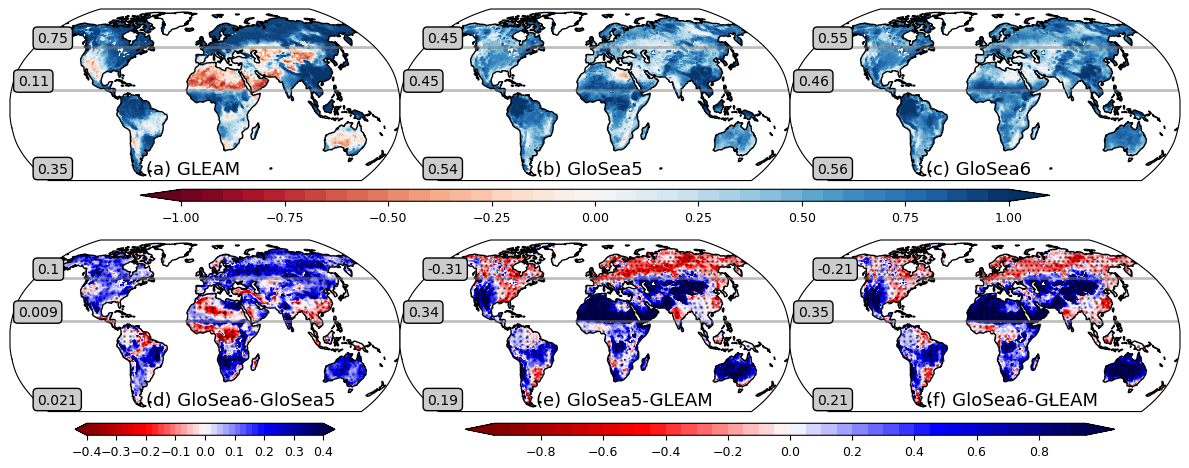

In [ ]:
import string
alphabet = list(string.ascii_lowercase)

nrows = 2
ncols = 3

map_name = 'R_Rnet_LH'
titles = ['(a) GLEAM','(b) GloSea5','(c) GloSea6','(d) GloSea6-GloSea5','(e) GloSea5-GLEAM','(f) GloSea6-GLEAM']

fname='./fig/'+map_name+'_maps_MJJA.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(13,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = plot_maps4.isel(maps=pp).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0).sel(lat=slice(-60,90))>=-1.)
    data3 = plot_sig4.isel(maps=pp).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0).sel(lat=slice(-60,90))>=-1.)
        
    dint=7
    
    if pp==3:
        cmaps = 'seismic_r'
        clevs = np.arange(-0.4,0.42,0.02)
        des = 3
    elif pp==4 or pp==5:
        cmaps = 'seismic_r'
        clevs = np.arange(-0.95,1.0,0.05)
        des = 2
    else:
        cmaps = 'RdBu'
        clevs = np.arange(-1.0,1.05,0.05)
        des = 2
        
    
    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmaps,extend='both')
    if pp==0:
        cs1 = cs
    elif pp==3:
        cs2 = cs
    elif pp==4:
        cs3 = cs
    
    # axs[pp].contourf(bias_map.lon,bias_map.lat, sig_map[pp,:,:].where(sig_map[pp,:,:]<=0.01), hatches=["."], alpha=0)
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4,transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    # if pp//ncols == 0:
    #     axs[pp].set_title(titles[pp], fontsize=14)
    # axs[pp].set_title(titles[pp],x=0.18,y=0.02, fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='gray', linestyle='-', linewidth=1)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='gray', linestyle='--', linewidth=0.8, alpha=0.5)
        
    aave1 = area_avg_weight(data.sel(lat=slice(50,90)), 'lon', 'lat')
    aave2 = area_avg_weight(data.sel(lat=slice(15,50)), 'lon', 'lat')
    aave3 = area_avg_weight(data.sel(lat=slice(-60,15)), 'lon', 'lat')
    
    bbox = dict(boxstyle ="round", fc ="0.8") 
    
    axs[pp].annotate('{}'.format(round(aave1,des)),xy=(0.07, 0.83), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave2,des)),xy=(0.02, 0.58), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave3,des)),xy=(0.07, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)

    axs[pp].gridlines(ylocs=[15, 50], xlocs=[], color='gray', linewidth=2, alpha=0.5);
    

    axs[pp].annotate('{}'.format(titles[pp]),xy=(0.35, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=13)
    
    
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.13, top=0.9, left=0.05, right=0.95,
                    wspace=0.0, hspace=0.0) # wspace: horizontal space, hspace: vertical space,


# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.15, 0.53, 0.7, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.14, 0.2, 0.02])
cbar_ax3 = fig.add_axes([0.4, 0.14, 0.5, 0.02])

# Draw the colorbar
cbar1=fig.colorbar(cs1, cax=cbar_ax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(cs2, cax=cbar_ax2,orientation='horizontal')
cbar2.ax.tick_params(labelsize=9)

cbar3=fig.colorbar(cs3, cax=cbar_ax3,orientation='horizontal')
cbar3.ax.tick_params(labelsize=9)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

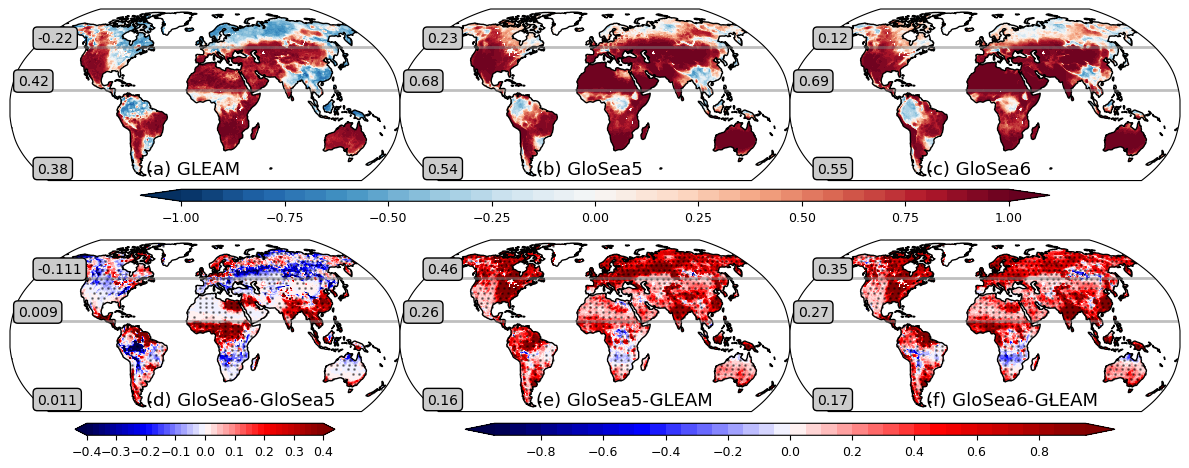

In [130]:
import string
alphabet = list(string.ascii_lowercase)

nrows = 2
ncols = 3

map_name = 'R_SSM_LH'
titles = ['(a) GLEAM','(b) GloSea5','(c) GloSea6','(d) GloSea6-GloSea5','(e) GloSea5-GLEAM','(f) GloSea6-GLEAM']

fname='./fig/'+map_name+'_maps_MJJA.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(13,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = plot_maps.isel(maps=pp).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0).sel(lat=slice(-60,90))>=-1.)
    data3 = plot_sig.isel(maps=pp).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0).sel(lat=slice(-60,90))>=-1.)
        
    dint=7
    
    
    if pp==3:
        cmaps = 'seismic'
        clevs = np.arange(-0.4,0.42,0.02)
        des = 3
    elif pp==4 or pp==5:
        cmaps = 'seismic'
        clevs = np.arange(-0.95,1.0,0.05)
        des = 2
    else:
        cmaps = 'RdBu_r'
        clevs = np.arange(-1.0,1.05,0.05)
        des = 2
        
    
    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmaps,extend='both')
    if pp==0:
        cs1 = cs
    elif pp==3:
        cs2 = cs
    elif pp==4:
        cs3 = cs
    
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4,transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    # if pp//ncols == 0:
    #     axs[pp].set_title(titles[pp], fontsize=14)
    # axs[pp].set_title(titles[pp],x=0.18,y=0.02, fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='gray', linestyle='-', linewidth=1)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    aave1 = area_avg_weight(data.sel(lat=slice(50,90)), 'lon', 'lat')
    aave2 = area_avg_weight(data.sel(lat=slice(15,50)), 'lon', 'lat')
    aave3 = area_avg_weight(data.sel(lat=slice(-60,15)), 'lon', 'lat')
    
    bbox = dict(boxstyle ="round", fc ="0.8") 
    
    axs[pp].annotate('{}'.format(round(aave1,des)),xy=(0.07, 0.83), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave2,des)),xy=(0.02, 0.58), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave3,des)),xy=(0.07, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)

    axs[pp].gridlines(ylocs=[15, 50], xlocs=[], color='gray', linewidth=2, alpha=0.5);
    
    axs[pp].annotate('{}'.format(titles[pp]),xy=(0.35, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=13)
    
    
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.13, top=0.9, left=0.05, right=0.95,
                    wspace=0.0, hspace=0.0) # wspace: horizontal space, hspace: vertical space,



# sys.exit()

# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.15, 0.53, 0.7, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.14, 0.2, 0.02])
cbar_ax3 = fig.add_axes([0.4, 0.14, 0.5, 0.02])

# Draw the colorbar
cbar1=fig.colorbar(cs1, cax=cbar_ax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(cs2, cax=cbar_ax2,orientation='horizontal')
cbar2.ax.tick_params(labelsize=9)

cbar3=fig.colorbar(cs3, cax=cbar_ax3,orientation='horizontal')
cbar3.ax.tick_params(labelsize=9)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

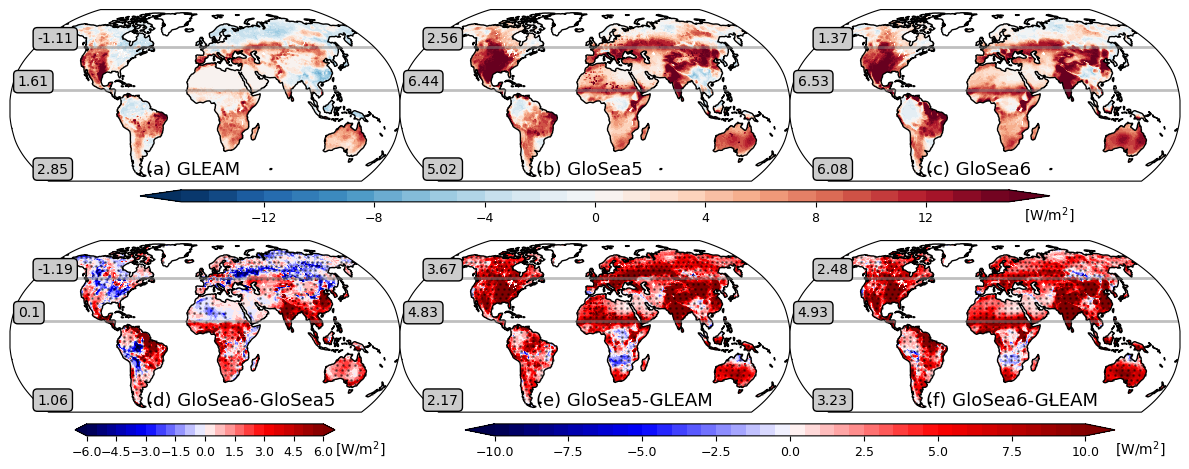

In [131]:
import string
alphabet = list(string.ascii_lowercase)

nrows = 2
ncols = 3

map_name = 'LC_SSM_LH'
titles = ['(a) GLEAM','(b) GloSea5','(c) GloSea6','(d) GloSea6-GloSea5','(e) GloSea5-GLEAM','(f) GloSea6-GLEAM']
units = ['W/m$^2$','W/m$^2$','W/m$^2$']

fname='./fig/'+map_name+'_maps_MJJA.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(13,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = plot_maps2.isel(maps=pp).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0).sel(lat=slice(-60,90))>=-1.)
    data3 = plot_sig2.isel(maps=pp).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0).sel(lat=slice(-60,90))>=-1.)
        
    dint=7
    
    
    if pp==3:
        cmaps = 'seismic'
        clevs = np.arange(-6,6.5,0.5)
        des = 2
    elif pp==4 or pp==5:
        cmaps = 'seismic'
        clevs = np.arange(-10,10.5,0.5)
        des = 2
    else:
        cmaps = 'RdBu_r'
        clevs = np.arange(-15,16,1)
        des = 2
        
    
    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmaps,extend='both')
    if pp==0:
        cs1 = cs
    elif pp==3:
        cs2 = cs
    elif pp==4:
        cs3 = cs
    
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4,transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    # if pp//ncols == 0:
    #     axs[pp].set_title(titles[pp], fontsize=14)
    # axs[pp].set_title(titles[pp],x=0.18,y=0.02, fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='gray', linestyle='-', linewidth=1)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    aave1 = area_avg_weight(data.sel(lat=slice(50,90)), 'lon', 'lat')
    aave2 = area_avg_weight(data.sel(lat=slice(15,50)), 'lon', 'lat')
    aave3 = area_avg_weight(data.sel(lat=slice(-60,15)), 'lon', 'lat')
    
    bbox = dict(boxstyle ="round", fc ="0.8") 
    
    axs[pp].annotate('{}'.format(round(aave1,des)),xy=(0.07, 0.83), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave2,des)),xy=(0.02, 0.58), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)
    axs[pp].annotate('{}'.format(round(aave3,des)),xy=(0.07, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=10, bbox=bbox)

    axs[pp].gridlines(ylocs=[15, 50], xlocs=[], color='gray', linewidth=2, alpha=0.5);
    
    axs[pp].annotate('{}'.format(titles[pp]),xy=(0.35, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=13)
    
    

# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.13, top=0.9, left=0.05, right=0.95,
                    wspace=0.0, hspace=0.0) # wspace: horizontal space, hspace: vertical space,



# sys.exit()

# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.15, 0.53, 0.7, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.14, 0.2, 0.02])
cbar_ax3 = fig.add_axes([0.4, 0.14, 0.5, 0.02])

# Draw the colorbar
cbar1=fig.colorbar(cs1, cax=cbar_ax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(cs2, cax=cbar_ax2,orientation='horizontal')
cbar2.ax.tick_params(labelsize=9)

cbar3=fig.colorbar(cs3, cax=cbar_ax3,orientation='horizontal')
cbar3.ax.tick_params(labelsize=9)

fig.text(0.83,0.50, '[{}]'.format(units[0]), color='black', size=10, rotation=0, horizontalalignment="left")
fig.text(0.30,0.11, '[{}]'.format(units[1]), color='black', size=10, rotation=0, horizontalalignment="left")
fig.text(0.90,0.11, '[{}]'.format(units[2]), color='black', size=10, rotation=0, horizontalalignment="left")

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

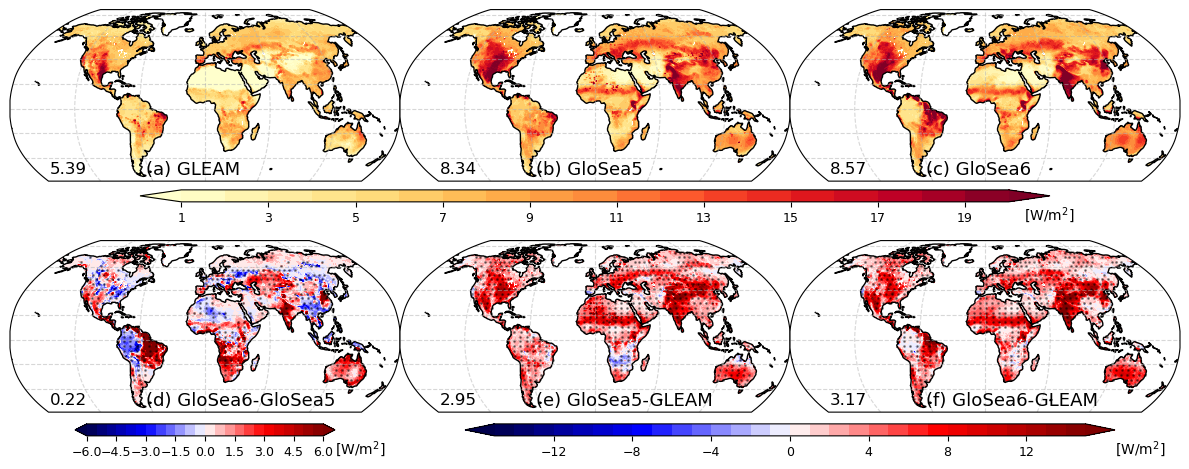

In [136]:
import string
alphabet = list(string.ascii_lowercase)

nrows = 2
ncols = 3

map_name = 'SD_SSM_LH'
titles = ['(a) GLEAM','(b) GloSea5','(c) GloSea6','(d) GloSea6-GloSea5','(e) GloSea5-GLEAM','(f) GloSea6-GLEAM']
units = ['W/m$^2$','W/m$^2$','W/m$^2$']

fname='./fig/'+map_name+'_maps_MJJA.png'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(13,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = plot_maps3.isel(maps=pp).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0).sel(lat=slice(-60,90))>=-1.)
    data3 = plot_sig3.isel(maps=pp).sel(lat=slice(-60,90)).where(plot_maps.isel(maps=0).sel(lat=slice(-60,90))>=-1.)
        
    dint=7
    
    
    if pp==3:
        cmaps = 'seismic'
        clevs = np.arange(-6,6.5,0.5)
        des = 2
    elif pp==4 or pp==5:
        cmaps = 'seismic'
        clevs = np.arange(-15,16,1)
        des = 2
    else:
        cmaps = 'YlOrRd'
        clevs = np.arange(1,21,1)
        des = 2
        
    
    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmaps,extend='both')
    if pp==0:
        cs1 = cs
    elif pp==3:
        cs2 = cs
    elif pp==4:
        cs3 = cs
    
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4,transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    # if pp//ncols == 0:
    #     axs[pp].set_title(titles[pp], fontsize=14)
    # axs[pp].set_title(titles[pp],x=0.18,y=0.02, fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='gray', linestyle='-', linewidth=1)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    aave = area_avg_weight(data, 'lon', 'lat')
    axs[pp].annotate('{}'.format(round(aave,des)),xy=(0.15, 0.07), xycoords='axes fraction',
                     horizontalalignment='center', verticalalignment='center', color='black', fontsize=12)
    
    axs[pp].annotate('{}'.format(titles[pp]),xy=(0.35, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=13)
    
    
    # Draw gridlines except for xlabels_top and ylabels_left
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    

# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.13, top=0.9, left=0.05, right=0.95,
                    wspace=0.0, hspace=0.0) # wspace: horizontal space, hspace: vertical space,


# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.15, 0.53, 0.7, 0.02])
cbar_ax2 = fig.add_axes([0.1, 0.14, 0.2, 0.02])
cbar_ax3 = fig.add_axes([0.4, 0.14, 0.5, 0.02])

# Draw the colorbar
cbar1=fig.colorbar(cs1, cax=cbar_ax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(cs2, cax=cbar_ax2,orientation='horizontal')
cbar2.ax.tick_params(labelsize=9)

cbar3=fig.colorbar(cs3, cax=cbar_ax3,orientation='horizontal')
cbar3.ax.tick_params(labelsize=9)

fig.text(0.83,0.50, '[{}]'.format(units[0]), color='black', size=10, rotation=0, horizontalalignment="left")
fig.text(0.30,0.11, '[{}]'.format(units[1]), color='black', size=10, rotation=0, horizontalalignment="left")
fig.text(0.90,0.11, '[{}]'.format(units[2]), color='black', size=10, rotation=0, horizontalalignment="left")

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()